# Identifying Shocks

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
path = '/home/dennis/Uni/TimeSeries/Python'
%run '/home/dennis/Uni/TimeSeries/Python/PS2/helper.py'
os.chdir(path)
#from helper import *

### Proprocessing and joining
Using the function from helper.py script, we join the 4 data sets into one data frame based on common time index. Before doing that we preprocess the data. Inflation needs to be computed as the growth rate of the Consumer Price Index (CPI). Furthermore, we take the log of GDP and M2. Since some data were only available monthly, we need to convert them. For GDP and M2 and   

In [237]:
# load data 
path = '/home/dennis/Uni/TimeSeries/Python/data/'
gdp = pd.read_csv(path +'RealGDPPerCapita.csv')
m2 = pd.read_csv(path + 'M2Real.csv')
fed_funds = pd.read_csv(path + 'fedFundsRate.csv')
inflation = pd.read_csv(path + 'Inflation.csv')         

# convert string timestamp to pandas time index     
dfs = [inflation, gdp, m2, fed_funds]
inflation, gdp, m2, fed_funds = [convert_date_column(df) for df in dfs]

# some preprocessing
fed_funds = convert_to_quarterly(fed_funds)
log_gdp, log_m2, log_ff = [np.log(df) for df in [gdp, m2, fed_funds]]

# join data
dfs = [inflation, log_gdp, log_m2, log_ff]
df_all = join_dfs_by_index(dfs)

# rename columns
colnames = ["inflation", "log_gdp", "log_m2", "log_ff"]
df_all.columns =  colnames
df_all.head()

,inflation,log_gdp,log_m2,log_ff
DATE,,,,
1960-01-01,0.2,9.763075,6.922939,2.482404
1960-04-01,0.1,9.755741,6.923530,2.468100
1960-07-01,0.0,9.754001,6.936440,2.406044
1960-10-01,0.7,9.737315,6.947264,2.175887
1961-01-01,0.0,9.740145,6.959019,1.930071


## Cheking for Trend and Stationarity
Plotting all 4 time series to get a visual impression whether trend is present.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f69030e2dd0>,
      dtype=object)

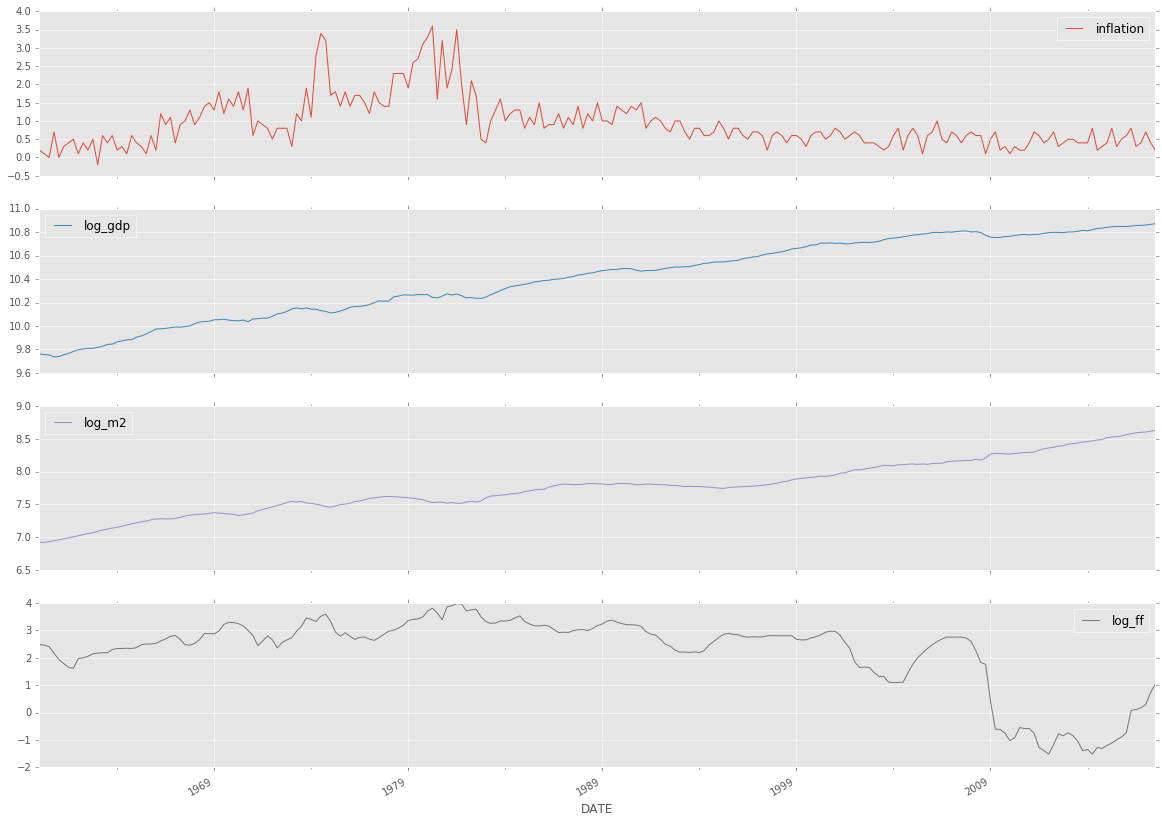

In [238]:
df_all.plot(subplots=True, figsize=(20,15))

The first three time series continuously growing. There seems to be no clear trend for the fed funds rate. On the other hand, this time series does not look stationary at all.

As a next step, we test for trend using the Augmented Dickey-Fuller Test. 

In [239]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x,colname):
    result = adfuller(x)
    print('ADF-Test Results for %s' % colname)
    print('Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
[adf_test(df_all[col],col) for col in colnames]

ADF-Test Results for inflation
Statistic: -1.307278
p-value: 0.625836
Critical Values:
	5%: -2.875
	1%: -3.461
	10%: -2.574
ADF-Test Results for log_gdp
Statistic: -2.083490
p-value: 0.251205
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574
ADF-Test Results for log_m2
Statistic: -0.239533
p-value: 0.933642
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574
ADF-Test Results for log_ff
Statistic: -2.061201
p-value: 0.260399
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574


[None, None, None, None]

All tests for each time series can not reject the $H_0$. Thus, we need to detrend each of them.

## Detrending Inflation and Fed Funds
Simplest Way: Take the first difference

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f69015bc850>,
      dtype=object)

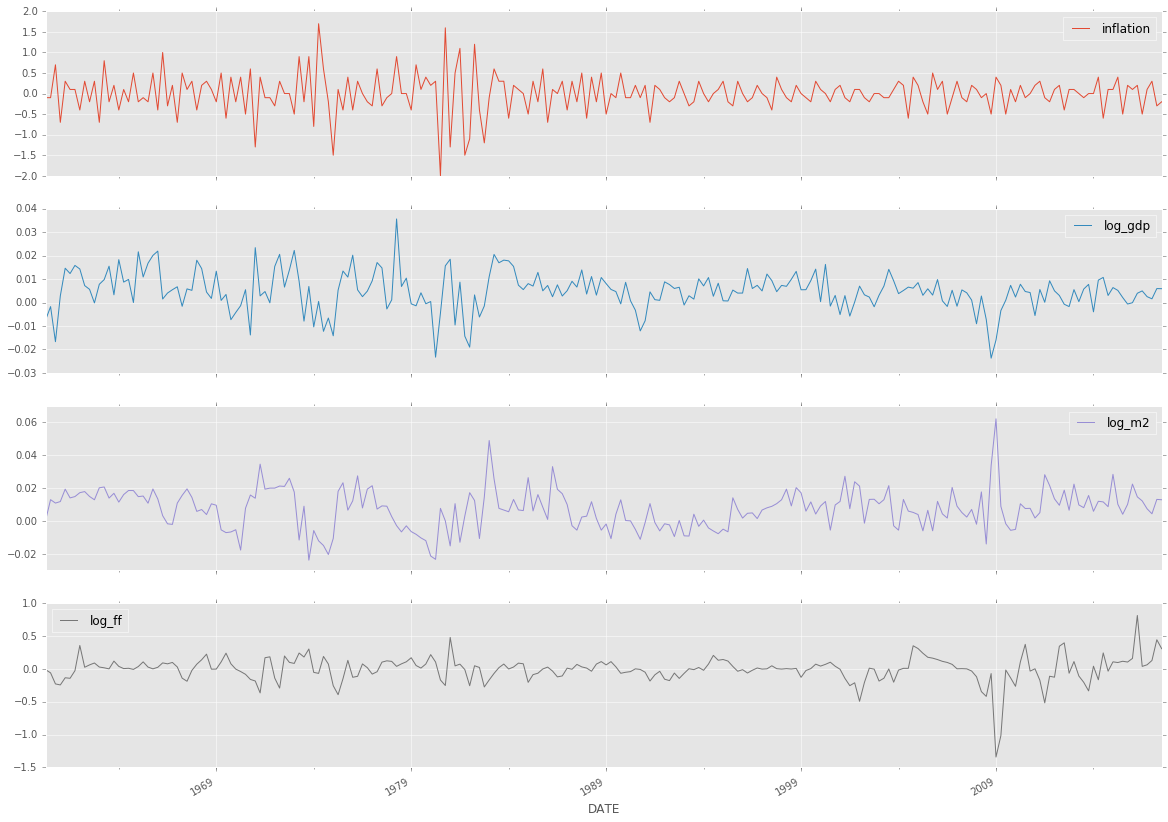

In [240]:
df_fd = df_all.diff(axis=0)[1:]
df_fd.plot(subplots=True, figsize=(20,15))

In [241]:
[adf_test(df_fd[col],col) for col in df_fd]

ADF-Test Results for inflation
Statistic: -6.890420
p-value: 0.000000
Critical Values:
	5%: -2.875
	1%: -3.461
	10%: -2.574
ADF-Test Results for log_gdp
Statistic: -7.407929
p-value: 0.000000
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574
ADF-Test Results for log_m2
Statistic: -5.398130
p-value: 0.000003
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574
ADF-Test Results for log_ff
Statistic: -5.784248
p-value: 0.000001
Critical Values:
	5%: -2.874
	1%: -3.459
	10%: -2.574


[None, None, None, None]

After taking first difference, time series of the plot look more stationary. The Augmented-Dickey-Fuller Tests also reject the $H_0$ for every time series now. Thus, we going to use the first difference for now on.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68feb47290>,
      dtype=object)

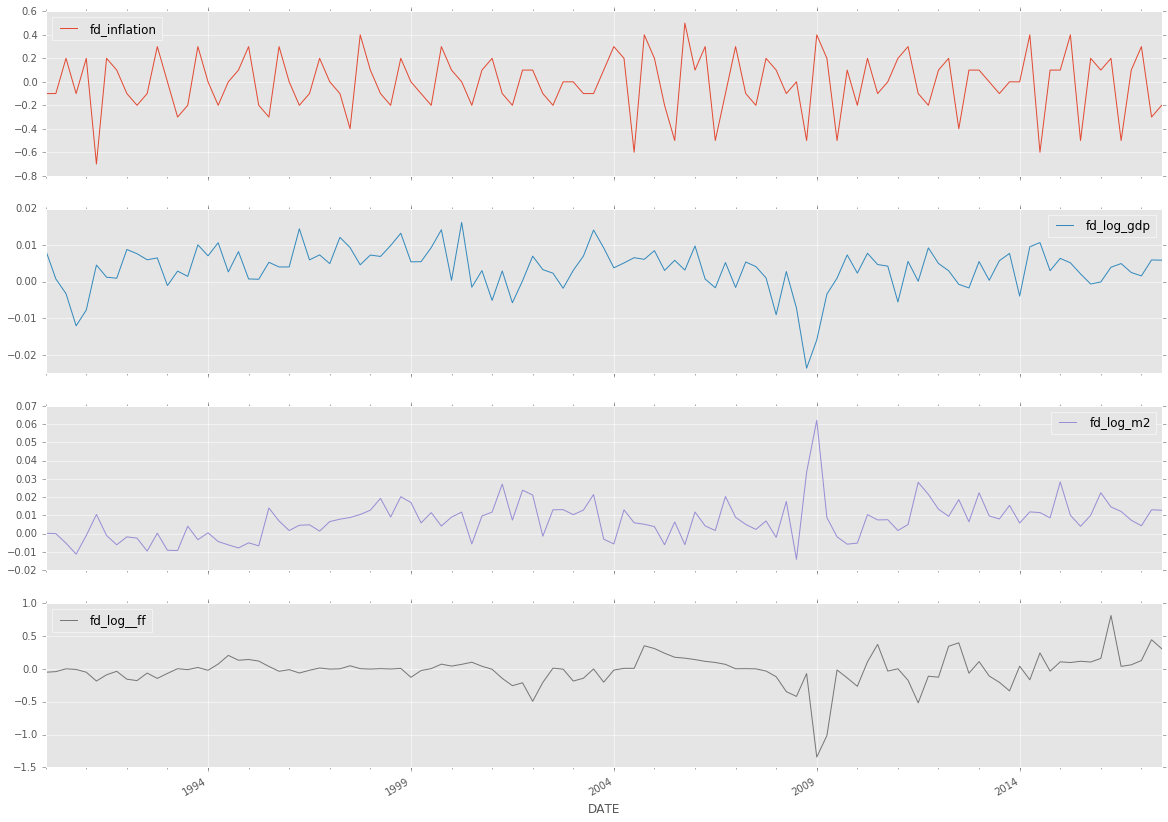

In [273]:
df = df_fd
colnames = ["fd_inflation", "fd_log_gdp", "fd_log_m2", "fd_log__ff"]
df.columns = colnames
df.head()
df = df["1990-01-01":]
df.plot(subplots=True,figsize=(20,15))

## Structural VAR Estimation
Now we are going to use the converted times series to estimate a Structural Vectorautoregressive Model (SVAR), i.e.

\begin{equation}
    \mathbf{B}_0 \mathbf{Z}_t = \mathbf{c} + \mathbf{B_1} \mathbf{Z}_{t-1} + \dots + \mathbf{B_p} \mathbf{Z}_{t-p} + \mathbf{\epsilon}_t    
\end{equation}

where 
\begin{equation*}
\mathbf{Z}_t =  \begin{bmatrix}
 \pi_t \\ \ln Y_t \\ \ln m_t \\ \ln R_t 
\end{bmatrix}
\end{equation*}

We are going to do this in two steps: 
- estimate a VAR(p) model 
- recover $B_0$ with recursive restriction or sign restriction



### Estimating VAR(p)
First we need to choose the optimal lag order of VAR(p)

In [274]:
from statsmodels.tsa.api import VAR
model = VAR(df)
model.select_order(10)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -25.08       -24.98    1.283e-11       -25.04
1        -25.75      -25.24*    6.530e-12       -25.55
2        -26.00       -25.07    5.111e-12       -25.62
3        -26.26       -24.91   3.976e-12*      -25.71*
4        -26.06       -24.30    4.893e-12       -25.34
5        -25.96       -23.79    5.425e-12       -25.08
6        -26.02       -23.43    5.239e-12       -24.97
7        -26.06       -23.06    5.123e-12       -24.85
8        -26.12       -22.70    5.026e-12       -24.73
9       -26.30*       -22.46    4.384e-12       -24.74
10       -26.30       -22.05    4.638e-12       -24.58
* Minimum



{'aic': 9, 'bic': 1, 'fpe': 3, 'hqic': 3}

AIC and the final prediction error would choose 3 lags, while BIC and the Hannan-Quinn Information Criterium (HQIC) would choose 1 lag. We going to use 3 lags.   

In [275]:
var_result = model.fit(maxlags=10, ic='aic')

# get model parameters
A = var_result.coefs # A_i = A[i-1]
U = var_result.resid
Sigma_U = var_result.sigma_u

# model summary
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 03, Feb, 2018
Time:                     16:49:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -22.5082
Nobs:                     102.000    HQIC:                  -24.7747
Log likelihood:           911.241    FPE:                4.27335e-12
AIC:                     -26.3170    Det(Omega_mle):     1.23911e-12
--------------------------------------------------------------------
Results for equation fd_inflation
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.084852         0.040417           -2.099           0.040
L1.fd_inflation        -0.778985         0.117623           -6.623           0.000
L1.fd_log_gdp          -0.210684         3.30

### Recursive Restrictions using Cholesky Decomposition

In [352]:
from scipy.linalg import cholesky
P = cholesky(Sigma_U, lower=True) 
# P.dot(P.T) == Sigma_U.values # Sigma_U = PP^T
B_0 = np.linalg.inv(P)  # B_0 = P^{-1}

Now lets plot the IRF. Statsmodels already provides a function, to plot the IRF. This function takes the model results and P as an input.
TODO: get $A_i = B_{0}^{-1} B_i$ and plot the IRF! Use constructure of VARResults to update var_model with new estimetors

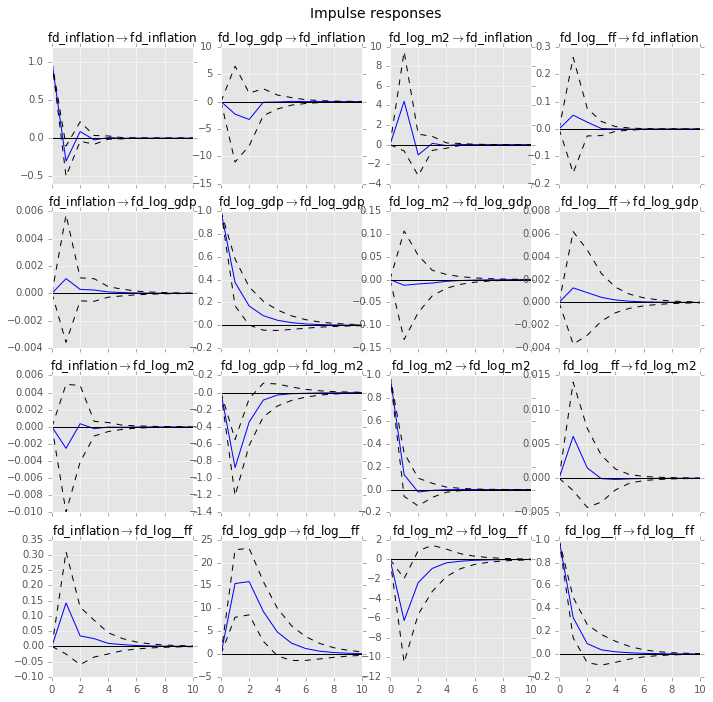

In [248]:
#TODO: write IRF yourself --> input P does not have an effect on plot
from statsmodels.tsa.vector_ar import irf
irf.IRAnalysis(var_result, P=P, periods=10).plot()

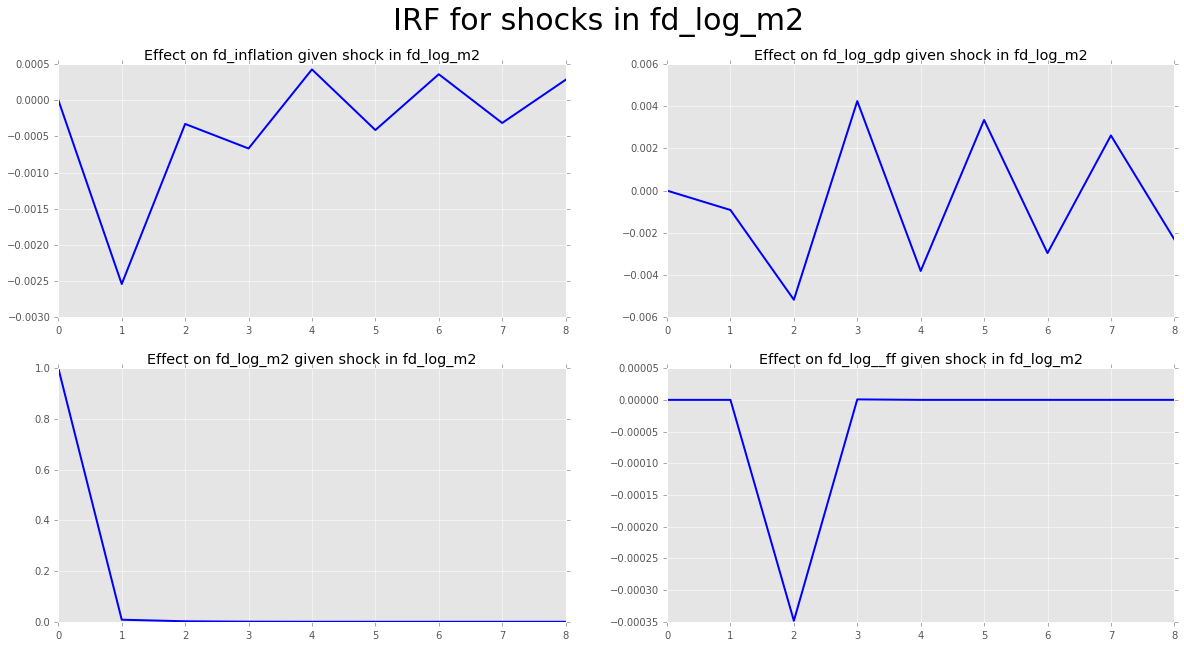

In [312]:
import numpy as np
import matplotlib.pyplot as plt

def plot_struc_irf(df,Theta,shock_in,horizon=10):
    """
    Returns IRF plots given a shock in a variable specifiied in shock_in
    """
    j = df.columns.get_loc(shock_in)
    plt.figure(1,figsize=(20,10))
    plt.suptitle("IRF for shocks in " + shock_in, fontsize=30)
    for i in range(0,df.shape[1]):
        irf = np.zeros((horizon+1,1))
        if (i == j):
            irf[0] = 1
        for h in range(0,horizon):
            irf[h+1] = Theta[:][h][j][i]
        plt.subplot(221 + i)
        plt.title("Effect on " + df.columns[i] + " given shock in " + shock_in)
        plt.plot(range(0,horizon+1), irf, color='b', linewidth=2.0)

def get_struct_ir(coefs,B_0,last_horizon):
    """
    Return all structural impulse responses given VAR(p) coefficients and B_0
    for number h = 1,..., last_horizon
    Result in a 3-dimensional array Theta of dimension (last_horizon,k,k)
    containing all impulse repsonses Theta_i for given horizon i 
    """
    p, k, k2 = coefs.shape
    assert(k == k2)
    A_companion = get_companion_matrix(coefs,p,k) 
    Theta = np.zeros((last_horizon,k,k))
    for i in range(0,last_horizon):
        Phi_i = get_reduced_form_ir(A_companion,p,k,i)
        if (i == 0):
            Theta_i = np.linalg.inv(B_0)
        else:
            Theta_i = np.dot(Phi_i,np.linalg.inv(B_0))
        Theta[i] = Theta_i
    return Theta


def get_reduced_form_ir(A_companion,p,k,horizon):
    """
    Return Reduce form impuls response
    Phi_i = J A^i J where i is the horizon and J := [I_k, 0_kxk(p-1)]
    """
    identity_k = np.identity(k)
    zeros_k_pk = np.zeros((k,k*(p-1)))
    J = np.concatenate((identity_k, zeros_k_pk), axis=1)
    Phi = np.dot(J,np.dot(A_companion**horizon,J.T))
    return Phi
    
def get_companion_matrix(coefs, k, p):
    """
    Return compansion matrix for the VAR(1) representation for a VAR(p) process
    (companion form)
    A = [A_1 A_2 ... A_p-1 A_p
         I_K 0       0     0
         0   I_K ... 0     0
         0 ...       I_K   0]
    """
    p, k, k2 = coefs.shape
    assert(k == k2)

    kp = k * p

    result = np.zeros((kp, kp))
    result[:k] = np.concatenate(coefs, axis=1)

    # Set I_K matrices
    if p > 1:
        result[np.arange(k, kp), np.arange(kp-k)] = 1

    return result

Theta = get_struct_ir(A,B_0,last_horizon=8)
plot_struc_irf(df,Theta,shock_in="fd_log_m2",horizon=8)

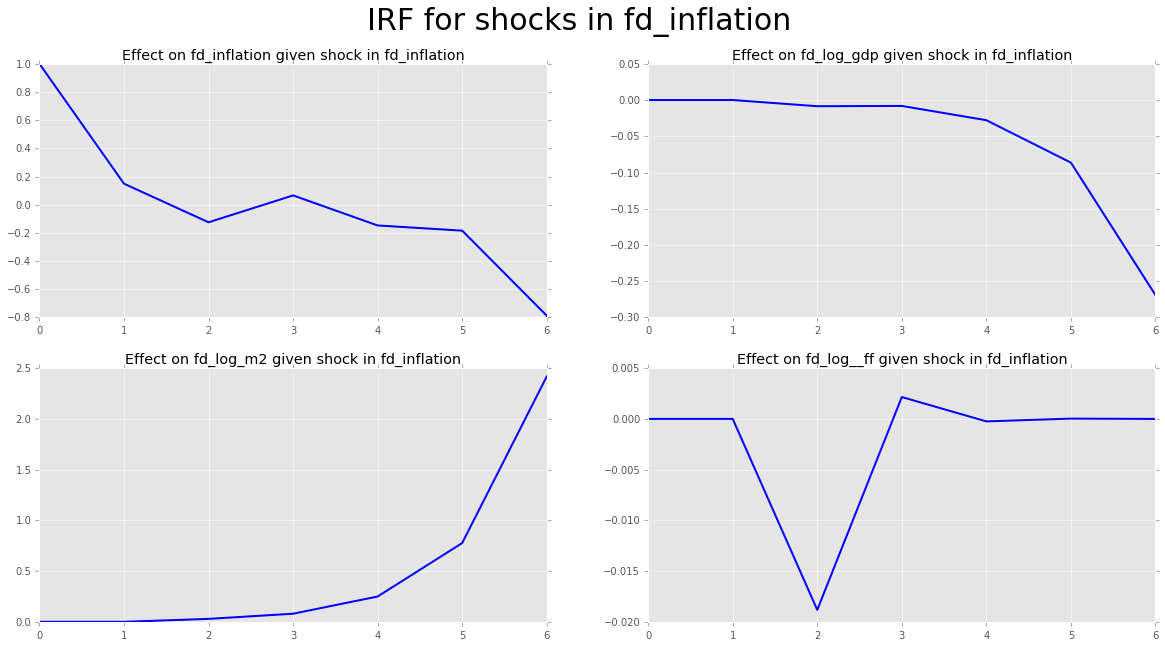

In [320]:
plot_struc_irf(df,Theta,shock_in="fd_inflation",horizon=6)

TODO: Interprete see Kilan & Lüktepohl

In [354]:
var_result.names

['fd_inflation', 'fd_log_gdp', 'fd_log_m2', 'fd_log__ff']

### Sign Restrictions
Ideas for sign restriction:
* (inflation,GDP) --> + (phillips curve)  $b_{12} = +$
* (m2,inflation) --> + $b_{3,1} = +$
* (ff, m2) - --> ff up, m2 down $b_{4,3} = -$
* (inflation,ff) + --> inflation up, ff goes up $b_{1,4}=+$

Thus we get

\begin{equation*}
\mathbf{B}_0 =  \begin{bmatrix}
 b_{11}       & +  & b_{13}  & + \\
 b_{21}  & b_{22}  & b_{2,3} & b_{2,4} \\ 
 +       & b_{32} & b_{33}   & b_{3,4} \\ 
 b_{41} & b_{42}  & -        & b_{44}
\end{bmatrix}
\end{equation*}


In [418]:
def generate_gaussian_matrix(k):
    mu, sigma = 0, 1
    W = np.empty((k,k))
    for i in range(0,k):
        W[i] = np.random.normal(mu, sigma, k)
    return W

def qr_with_positive_diagonals(W):
    Q, R  = np.linalg.qr(W)
    R_diag = np.diagonal(R)
    for i in range(0,Q.shape[0]):
        if (R_diag[i] < 0):
            Q[i][i] *= -1
    return Q

def satisfies_restrictions(candidate, restrictions):
    restrictions_fulfilled = True
    for restriction in restrictions:
        i, j = restriction[0]
        element_to_check = B_0[i][j]
        if (np.sign(element_to_check) != np.sign(restriction[1])):
            restrictions_fulfilled = False
    return restrictions_fulfilled

restrictions = np.array([[(0,1),1],[(0,3),1],[(2,0),1],[(3,2),-1]])
restrictions_fulfilled = False
counter = 0
while (restrictions_fulfilled is False):
    counter += 1
    W = generate_gaussian_matrix(4)
    Q = qr_with_positive_diagonals(W)
    P = cholesky(Sigma_U, lower=True) 
    B_0 = P.dot(Q)
    restrictions_fulfilled = satisfies_restrictions(B_0,restrictions)
    print('Iteration %i' % counter)
print B_0

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
[[ 0.07220113  0.1226545  -0.04482578  0.00054984]
 [-0.0044089  -0.00343795 -0.00114916 -0.00183357]
 [ 0.00303987 -0.00088174  0.00486374 -0.0059928 ]
 [-0.01203973 -0.05019508 -0.15509951 -0.08359612]]


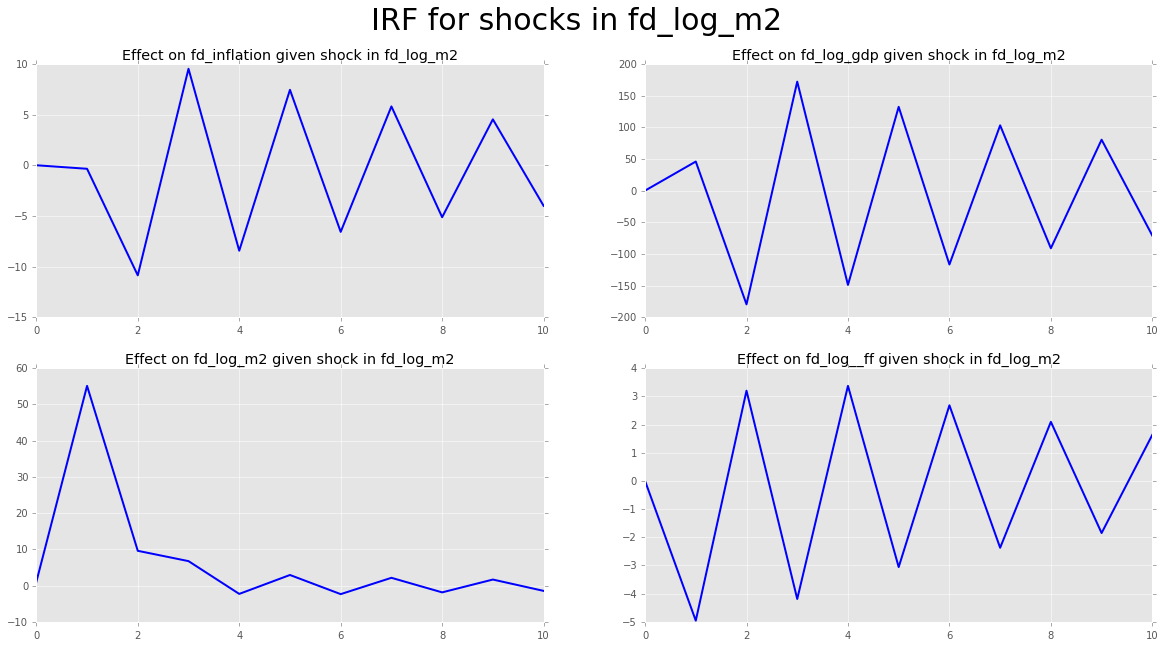

In [419]:
Theta = get_struct_ir(A,B_0,last_horizon=10)
plot_struc_irf(df,Theta,shock_in="fd_log_m2",horizon=10)

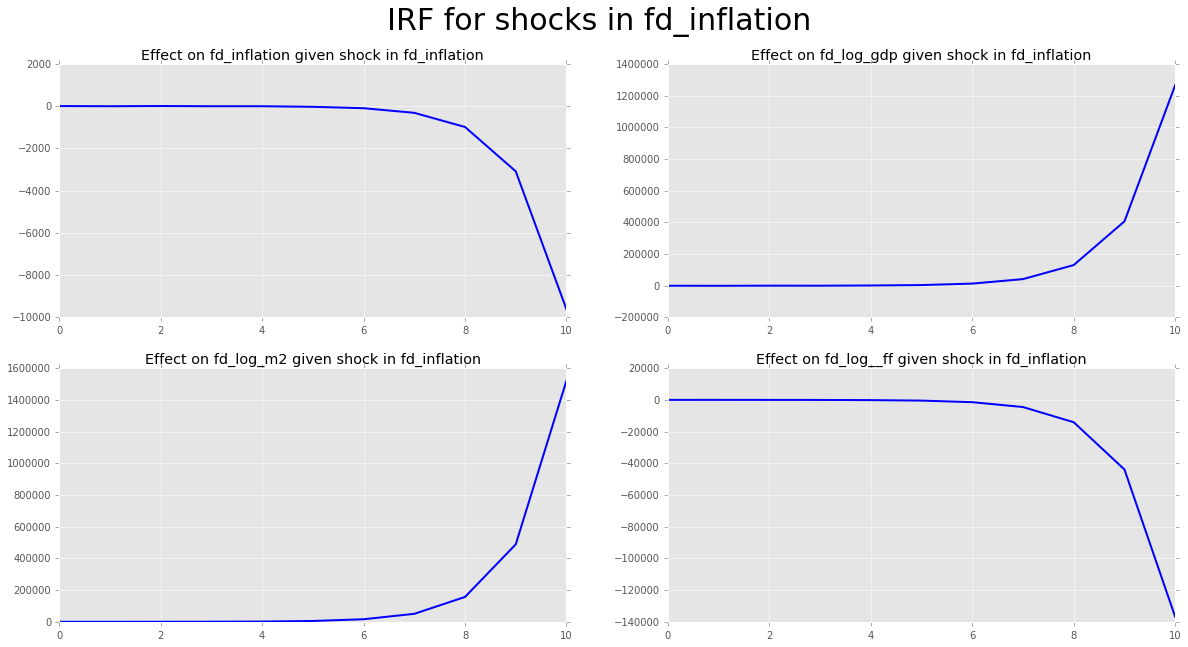

In [420]:
plot_struc_irf(df,Theta,shock_in="fd_inflation",horizon=10)

IRF for shock in inflation is completly determined by the sign restrictions